In [1]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(4)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM,Dropout
import math
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from numpy import array

In [5]:
data = pd.read_csv("../data/RICB.csv")
data

,DateTime,RICB
0,2020-04-23 06:34:02,70
1,2020-04-23 09:34:02,70
2,2020-04-24 06:34:01,70
3,2020-04-24 09:34:02,70
4,2020-04-27 06:33:57,70
...,...,...
2497,2022-07-14 04:55:53,70
2498,2022-07-14 05:55:54,70
2499,2022-07-14 07:55:52,70
2500,2022-07-14 08:55:53,70


In [6]:
#Changing datetime to datetime format
data['DateTime'] = pd.to_datetime(data['DateTime']).dt.date

#renaming the columns
data.rename(columns = {'DateTime':'date','RICB':'price'}, inplace = True)
data['date'] = pd.to_datetime(data['date'],format = "%Y-%m-%d")
data

,date,price
0,2020-04-23,70
1,2020-04-23,70
2,2020-04-24,70
3,2020-04-24,70
4,2020-04-27,70
...,...,...
2497,2022-07-14,70
2498,2022-07-14,70
2499,2022-07-14,70
2500,2022-07-14,70


In [7]:
data = data.groupby('date').mean()
data

,price
date,
2020-04-23,70.0
2020-04-24,70.0
2020-04-27,70.0
2020-04-28,70.0
2020-04-29,70.0
...,...
2022-07-11,70.0
2022-07-12,70.0
2022-07-13,70.0


In [8]:
data1 = data.reset_index()['price']
#data.columns=["confirmed"]
data1

0      70.0
1      70.0
2      70.0
3      70.0
4      70.0
       ... 
543    70.0
544    70.0
545    70.0
546    70.0
547    70.0
Name: price, Length: 548, dtype: float64

In [9]:
print("Size of the dataset: ",data1.shape)
print("Checking for null values:\n",data1.isnull().sum())
print("Checking Data-type of each column:\n",data1.dtypes)

Size of the dataset:  (548,)
Checking for null values:
 0
Checking Data-type of each column:
 float64


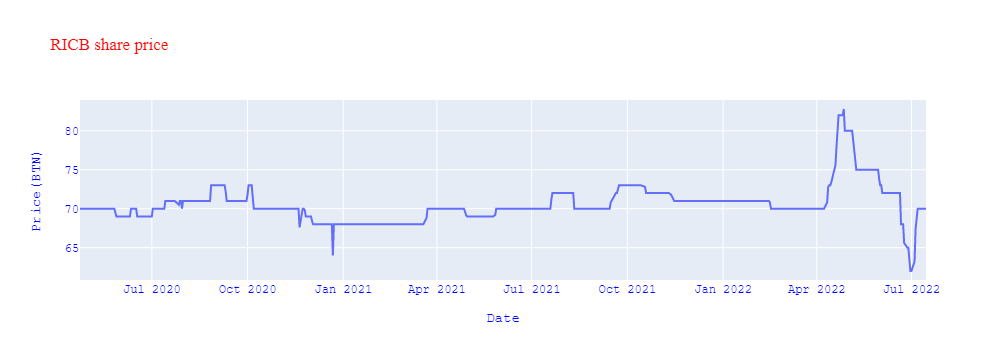

In [11]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x = data.index, y = data["price"], name="price", mode="lines"))

fig.update_layout(
    title = 'RICB share price',
    font_family="Courier New",
    font_color="blue",
    title_font_family="Times New Roman",
    title_font_color="red",
    xaxis_title = 'Date',
    yaxis_title = 'Price(BTN)'
)


fig.show()

In [12]:
scaler=MinMaxScaler(feature_range=(0,1))
#data=scaler.fit_transform(data)
data1=scaler.fit_transform(np.array(data1).reshape(-1,1))

In [13]:
training_size=int(len(data1)*0.65)
test_size=len(data1)-training_size
train_data,test_data=data1[0:training_size,:],data1[training_size:len(data1),:1]

In [14]:
len(train_data)

356

In [15]:
training_size,test_size

(356, 192)

In [16]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [17]:
import numpy
time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [18]:
print(X_train.shape), print(y_train.shape)

(345, 10)
(345,)


(None, None)

##### print(X_test.shape), print(ytest.shape)

In [19]:
X_train.shape[1]

10

In [20]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [21]:
#ytest

In [22]:
model=Sequential()
model.add(LSTM(64,activation='relu', return_sequences=False,input_shape=(time_step,1)))
#model.add(LSTM(32,activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(8))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,verbose=2)

Epoch 1/200
11/11 - 1s - loss: 0.0764 - val_loss: 0.0318 - 1s/epoch - 104ms/step
Epoch 2/200
11/11 - 0s - loss: 0.0054 - val_loss: 0.0135 - 123ms/epoch - 11ms/step
Epoch 3/200
11/11 - 0s - loss: 0.0047 - val_loss: 0.0107 - 88ms/epoch - 8ms/step
Epoch 4/200
11/11 - 0s - loss: 0.0021 - val_loss: 0.0136 - 71ms/epoch - 6ms/step
Epoch 5/200
11/11 - 0s - loss: 0.0018 - val_loss: 0.0096 - 82ms/epoch - 7ms/step
Epoch 6/200
11/11 - 0s - loss: 0.0016 - val_loss: 0.0094 - 74ms/epoch - 7ms/step
Epoch 7/200
11/11 - 0s - loss: 0.0015 - val_loss: 0.0103 - 77ms/epoch - 7ms/step
Epoch 8/200
11/11 - 0s - loss: 0.0015 - val_loss: 0.0096 - 76ms/epoch - 7ms/step
Epoch 9/200
11/11 - 0s - loss: 0.0014 - val_loss: 0.0092 - 72ms/epoch - 7ms/step
Epoch 10/200
11/11 - 0s - loss: 0.0014 - val_loss: 0.0094 - 71ms/epoch - 6ms/step
Epoch 11/200
11/11 - 0s - loss: 0.0014 - val_loss: 0.0090 - 91ms/epoch - 8ms/step
Epoch 12/200
11/11 - 0s - loss: 0.0014 - val_loss: 0.0089 - 77ms/epoch - 7ms/step
Epoch 13/200
11/11 - 0s

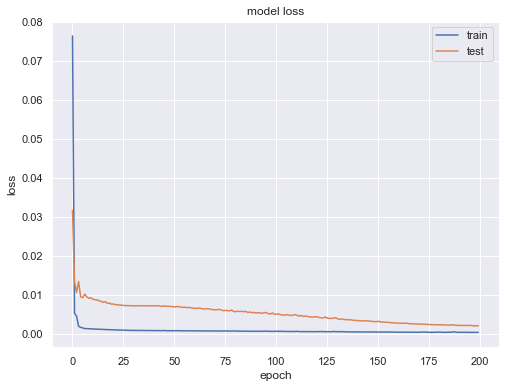

In [25]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [26]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

6/6 [==============================] - 0s 2ms/step


In [27]:
rstrain_predict=scaler.inverse_transform(train_predict)
rstest_predict=scaler.inverse_transform(test_predict)
rsytest=scaler.inverse_transform(np.array(ytest).reshape(-1,1))
rsytrain=scaler.inverse_transform(np.array(y_train).reshape(-1,1))


In [28]:
#rsytesty_trainre=scaler.inverse_transform(np.array([y_train]).reshape(-1,1))

In [29]:
#rsytrain

In [30]:
RMSE_train=math.sqrt(mean_squared_error(rsytrain,rstrain_predict))
print(RMSE_train)

0.4742634714298717


In [31]:
RMSE_test=math.sqrt(mean_squared_error(rsytest,rstest_predict))
MAE_test=mean_absolute_error(rsytest,rstest_predict)
R2_test=r2_score(rsytest,rstest_predict)
print("RMSE:", RMSE_test)
print("MAE:", MAE_test)
print("R-Squared:", R2_test)


RMSE: 0.9797655863082023
MAE: 0.4828653915152366
R-Squared: 0.9039625540326083


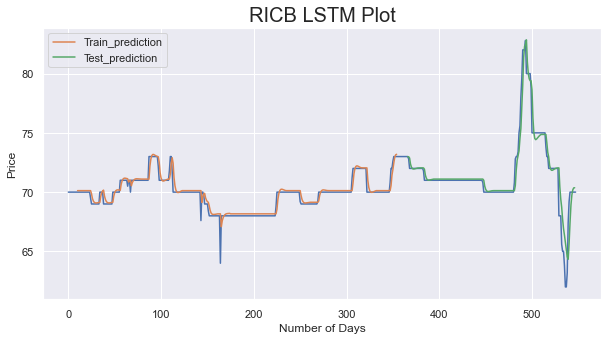

In [33]:
look_back=10
trainPredictPlot = numpy.empty_like(data1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = rstrain_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(data1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data1)-1, :] = rstest_predict
# plot baseline and predictions
plt.figure(figsize=(10,5))
plt.plot(scaler.inverse_transform(data1))
plt.plot(trainPredictPlot,label='Train_prediction')
plt.plot(testPredictPlot, label='Test_prediction')
plt.title('RICB LSTM Plot', fontsize=20)
plt.ylabel('Price')
plt.xlabel('Number of Days')
plt.legend()
plt.show()

In [34]:
len(test_data)

192

In [35]:
x_input=test_data[182:].reshape(1,-1)
x_input.shape

(1, 10)

In [36]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.05769230769230793,
 0.259615384615385,
 0.34615384615384626,
 0.3846153846153846,
 0.3846153846153846,
 0.3846153846153846,
 0.3846153846153846,
 0.3846153846153846,
 0.3846153846153846,
 0.3846153846153846]

In [37]:
lst_output=[]
n_steps=10
i=0
while(i<30):
    
    if(len(temp_input)>10):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

#print(lst_output)

In [38]:
forecast_rescaled=scaler.inverse_transform(lst_output)

In [39]:
forecast_rescaled

array([[70.23848481],
       [70.29231963],
       [70.35709362],
       [70.43450961],
       [70.51846294],
       [70.60324569],
       [70.68824043],
       [70.77301016],
       [70.85682402],
       [70.9393671 ],
       [71.02056255],
       [71.10159931],
       [71.18110247],
       [71.25859036],
       [71.33412066],
       [71.40705671],
       [71.47746983],
       [71.54498186],
       [71.60975089],
       [71.67175398],
       [71.73097377],
       [71.78744373],
       [71.84122338],
       [71.89237409],
       [71.94097271],
       [71.98709798],
       [72.03083606],
       [72.07227745],
       [72.1115077 ],
       [72.1486167 ]])

In [40]:
day_new=np.arange(0,547)
day_pred=np.arange(547,577)

In [41]:
day_pred

array([547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559,
       560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572,
       573, 574, 575, 576])

In [42]:
len(data1)

548

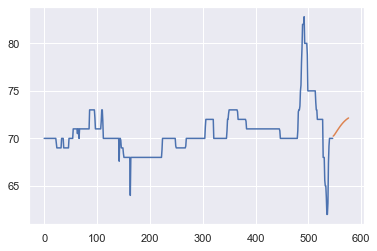

In [43]:
plt.plot(day_new,scaler.inverse_transform(data1[1:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))
plt.show()

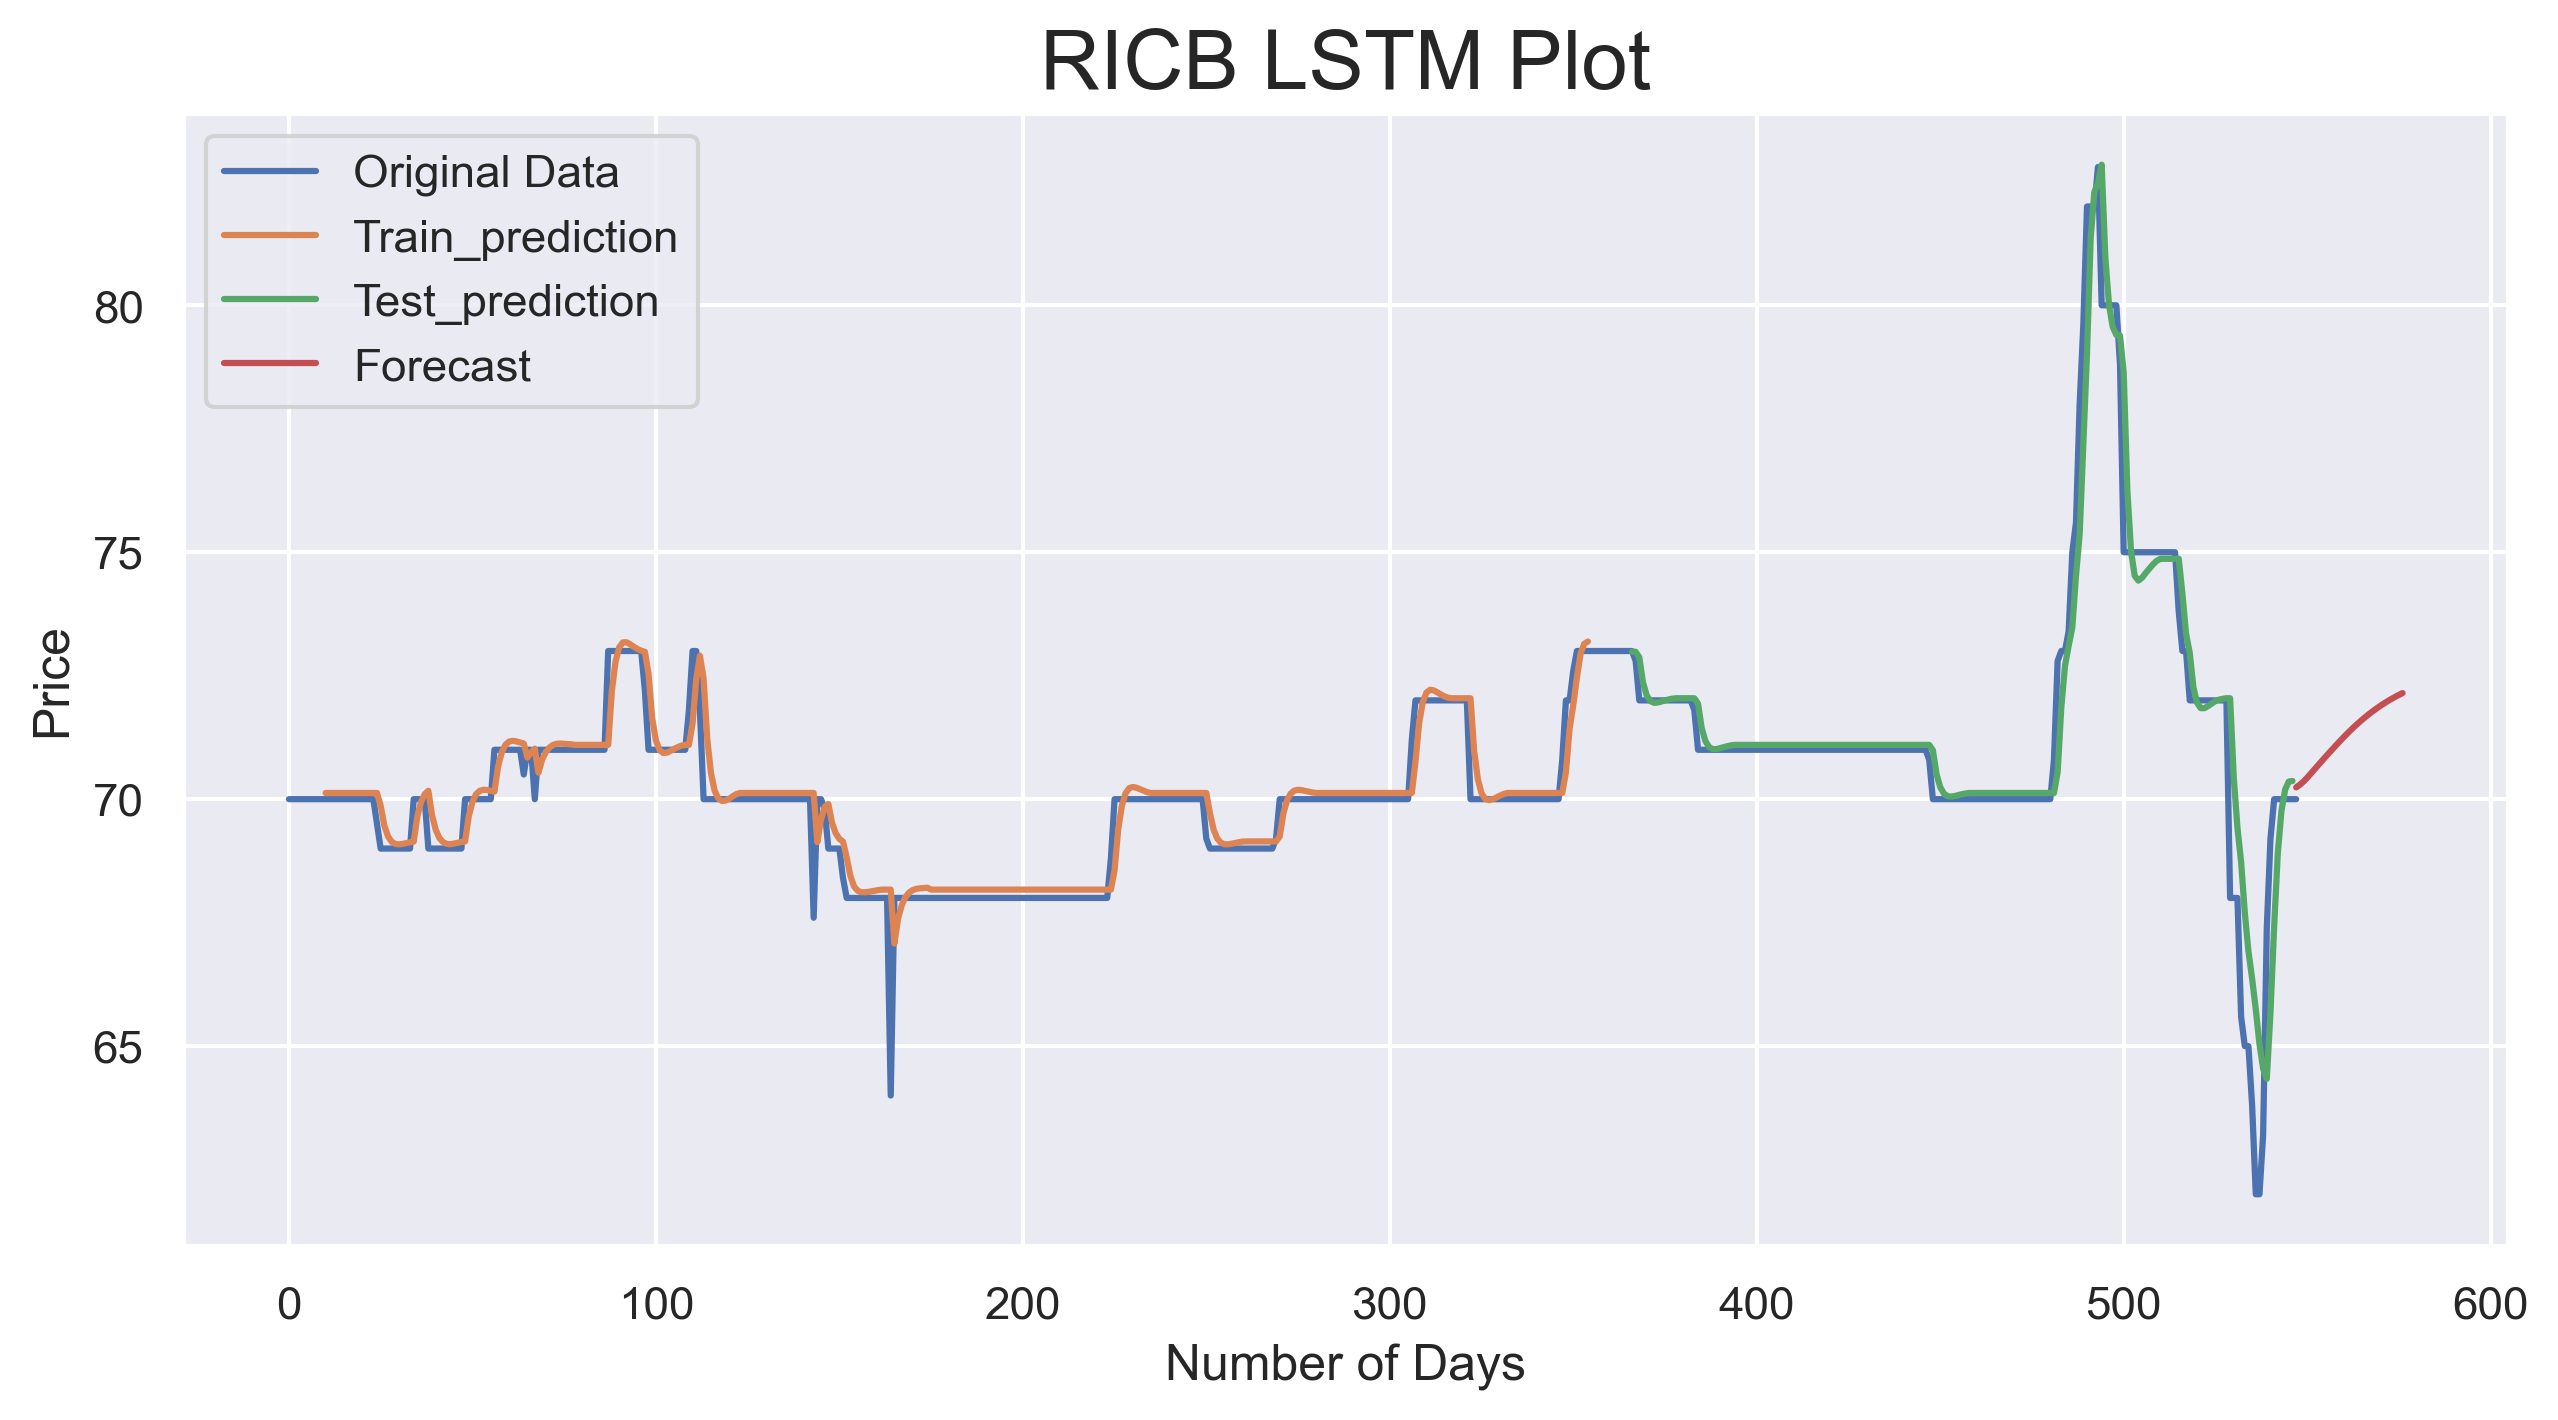

In [45]:
plt.figure(figsize=(10,5),dpi=300)
plt.plot(scaler.inverse_transform(data1), label='Original Data')
plt.plot(trainPredictPlot,label='Train_prediction')
plt.plot(testPredictPlot, label='Test_prediction')
plt.plot(day_pred,scaler.inverse_transform(lst_output), label='Forecast')
plt.title('RICB LSTM Plot', fontsize=20)
plt.ylabel('Price')
plt.xlabel('Number of Days')
plt.legend()
plt.show()

In [46]:
len(testPredictPlot)

548

In [47]:
np.count_nonzero(np.isnan(testPredictPlot))

367

In [48]:
#convert numpy array to DF
test = pd.DataFrame(testPredictPlot, columns = ['predicted_price'])
test.head()

,predicted_price
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [49]:
test.isnull().sum()

predicted_price    367
dtype: int64

In [50]:
test = test.dropna()
test

,predicted_price
366,72.984489
367,72.984489
368,72.871384
369,72.364098
370,72.104401
...,...
542,68.908272
543,69.768028
544,70.193840
545,70.357216


In [51]:
training_size=int(len(data1)*0.65)
training_size

356

In [52]:
#to know the date of test data
data.iloc[356+10:]  #10 for that time steps

,price
date,
2021-10-14,73.0
2021-10-18,72.8
2021-10-19,72.0
2021-10-20,72.0
2021-10-21,72.0
...,...
2022-07-11,70.0
2022-07-12,70.0
2022-07-13,70.0


In [53]:
test['date'] = pd.date_range(start='2021-10-14', periods=181, freq='D')
test

,predicted_price,date
366,72.984489,2021-10-14
367,72.984489,2021-10-15
368,72.871384,2021-10-16
369,72.364098,2021-10-17
370,72.104401,2021-10-18
...,...,...
542,68.908272,2022-04-08
543,69.768028,2022-04-09
544,70.193840,2022-04-10
545,70.357216,2022-04-11


In [54]:
test = test.set_index('date')

In [55]:
test

,predicted_price
date,
2021-10-14,72.984489
2021-10-15,72.984489
2021-10-16,72.871384
2021-10-17,72.364098
2021-10-18,72.104401
...,...
2022-04-08,68.908272
2022-04-09,69.768028
2022-04-10,70.193840


In [56]:
test = test.to_csv('predictedData/ricb_lstm_testPred.csv')

In [57]:
type(forecast_rescaled)

numpy.ndarray

In [58]:
forecast = pd.DataFrame(forecast_rescaled, columns = ['predicted_price'])
forecast.head()

,predicted_price
0,70.238485
1,70.292320
2,70.357094
3,70.434510
4,70.518463


In [59]:
data

,price
date,
2020-04-23,70.0
2020-04-24,70.0
2020-04-27,70.0
2020-04-28,70.0
2020-04-29,70.0
...,...
2022-07-11,70.0
2022-07-12,70.0
2022-07-13,70.0


In [60]:
forecast['date'] = pd.date_range(start='2021-10-13', periods=30, freq='D')
forecast.set_index('date')

,predicted_price
date,
2021-10-13,70.238485
2021-10-14,70.292320
2021-10-15,70.357094
2021-10-16,70.434510
2021-10-17,70.518463
2021-10-18,70.603246
2021-10-19,70.688240
2021-10-20,70.773010
2021-10-21,70.856824


In [61]:
forecast = forecast.to_csv('predictedData/ricb_lstm_forecast.csv')